In [4]:
import copy
import torch
import argparse
import numpy as np
import umap
from torchvision import datasets, transforms
import torchvision
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score,\
f1_score, roc_auc_score, roc_curve, accuracy_score, matthews_corrcoef as mcc
from torch.utils.data import Subset
import pandas as pd
from sklearn.datasets import make_classification, make_blobs
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

import numbers
import torch.nn as nn
from read_patients import *
# from cac import batch_cac
# from kmeans import batch_KMeans
# from meanshift import batch_MeanShift
# from autoencoder import AutoEncoder
from sklearn.metrics import davies_bouldin_score as dbs, adjusted_rand_score as ari, silhouette_samples as sil_sam
from matplotlib import pyplot as plt
color = ['grey', 'red', 'blue', 'pink', 'brown', 'black', 'magenta', 'purple', 'orange', 'cyan', 'olive']

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

class AutoEncoder(nn.Module):
    def __init__(self, args):
        super(AutoEncoder, self).__init__()
        self.args = args
        self.input_dim = args.input_dim
        self.output_dim = self.input_dim
        self.hidden_dims = args.hidden_dims
        self.hidden_dims.append(args.latent_dim)
        self.dims_list = (args.hidden_dims + 
                          args.hidden_dims[:-1][::-1])  # mirrored structure
        self.n_layers = len(self.dims_list)
        self.n_clusters = args.n_clusters
        self.n_classes = args.n_classes
        
        # Validation check
        assert self.n_layers % 2 > 0
        assert self.dims_list[self.n_layers // 2] == args.latent_dim
        
        # Encoder Network
        layers = OrderedDict()
        for idx, hidden_dim in enumerate(self.hidden_dims):
            if idx == 0:
                layers.update(
                    {'linear0': nn.Linear(self.input_dim, hidden_dim),
                     'activation0': nn.ReLU()
                    })
            else:
                layers.update(
                    {'linear{}'.format(idx): nn.Linear(
                        self.hidden_dims[idx-1], hidden_dim),
                     'activation{}'.format(idx): nn.ReLU(),
                     'bn{}'.format(idx): nn.BatchNorm1d(self.hidden_dims[idx])
                    })
        self.encoder = nn.Sequential(layers)
        
        # Decoder Network
        layers = OrderedDict()
        tmp_hidden_dims = self.hidden_dims[::-1]
        for idx, hidden_dim in enumerate(tmp_hidden_dims):
            if idx == len(tmp_hidden_dims) - 1:
                layers.update(
                    {'linear{}'.format(idx): nn.Linear(
                        hidden_dim, self.output_dim),
                    })
            else:
                layers.update(
                    {'linear{}'.format(idx): nn.Linear(
                        hidden_dim, tmp_hidden_dims[idx+1]),
                     'activation{}'.format(idx): nn.ReLU(),
                     'bn{}'.format(idx): nn.BatchNorm1d(tmp_hidden_dims[idx+1])
                    })
        self.decoder = nn.Sequential(layers)

        # Classification Head
#         self.classifiers = []
#         for _ in range(self.n_clusters):
#             self.classifiers.append(
#                 nn.Sequential(
#                     nn.Linear(20, 16),
#                     nn.ReLU(),
#                     nn.Linear(16, 8),
#                     nn.ReLU(),
#                     nn.Linear(8, self.n_classes)))


    def __repr__(self):
        repr_str = '[Structure]: {}-'.format(self.input_dim)
        for idx, dim in enumerate(self.dims_list):
                repr_str += '{}-'.format(dim)
        repr_str += str(self.output_dim) + '\n'
        repr_str += '[n_layers]: {}'.format(self.n_layers) + '\n'
        repr_str += '[n_clusters]: {}'.format(self.n_clusters) + '\n'
        repr_str += '[n_classes]: {}'.format(self.n_classes) + '\n'
        repr_str += '[input_dims]: {}'.format(self.input_dim)
        return repr_str
    
    def __str__(self):
        return self.__repr__()
    
    def forward(self, X, latent=False, classifier_idx=0):
        body_output = self.encoder(X)
        if latent:
            return body_output
#         probs = self.classifiers[classifier_idx](body_output)
        return self.decoder(body_output), _

In [3]:
## Batch k-Means

def _parallel_compute_distance(X, cluster):
    n_samples = X.shape[0]
    dis_mat = np.zeros((n_samples, 1))
    for i in range(n_samples):
        dis_mat[i] += np.sqrt(np.sum((X[i] - cluster) ** 2, axis=0))
    return dis_mat

class batch_KMeans(object):
    def __init__(self, args):
        self.args = args
        self.latent_dim = args.latent_dim
        self.n_clusters = args.n_clusters
        self.clusters = np.zeros((self.n_clusters, self.latent_dim))
        self.count = 100 * np.ones((self.n_clusters))  # serve as learning rate
        self.n_jobs = args.n_jobs
        self.positive_centers = np.zeros((self.n_clusters, self.latent_dim))
        self.negative_centers = np.zeros((self.n_clusters, self.latent_dim))
        self.cluster_stats = np.zeros((self.n_clusters,2))

    
    def _compute_dist(self, X):
        dis_mat = Parallel(n_jobs=self.n_jobs)(
            delayed(_parallel_compute_distance)(X, self.clusters[i])
            for i in range(self.n_clusters))
        dis_mat = np.hstack(dis_mat)
        
        return dis_mat


    def init_cluster(self, X, y=None, indices=None):
        """ Generate initial clusters using sklearn.Kmeans """
        model = KMeans(n_clusters=self.n_clusters,
                       n_init=20)
        model.fit(X)
        self.clusters = model.cluster_centers_  # copy clusters
        labels = model.labels_

    def update_cluster(self, X, cluster_idx):
        """ Update clusters in Kmeans on a batch of data """
        n_samples = X.shape[0]
        for i in range(n_samples):
            self.count[cluster_idx] += 1
            eta = 1.0 / self.count[cluster_idx]
            updated_cluster = ((1 - eta) * self.clusters[cluster_idx] + 
                               eta * X[i])
            self.clusters[cluster_idx] = updated_cluster
    

    def update_assign(self, X, y=None):
        """ Assign samples in `X` to clusters """
        dis_mat = self._compute_dist(X)
        new_labels = np.argmin(dis_mat, axis=1)

        return new_labels

In [4]:
import umap
import numpy as np
from sklearn.cluster import KMeans
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from sklearn.metrics import adjusted_rand_score as ari

class batch_cac(object):    
    def __init__(self, args):
        self.args = args
        self.latent_dim = args.latent_dim
        self.n_clusters = args.n_clusters
        self.cluster_stats = np.zeros((self.n_clusters,2))
        self.clusters = np.zeros((self.n_clusters, self.latent_dim))
        self.positive_centers = np.zeros((self.n_clusters, self.latent_dim))
        self.negative_centers = np.zeros((self.n_clusters, self.latent_dim))
        self.positive_sse = np.zeros(self.n_clusters)
        self.negative_sse = np.zeros(self.n_clusters)
        self.count = 100 * np.ones((self.n_clusters))  # serve as learning rate
        self.n_jobs = args.n_jobs


    def calculate_gamma_old(self, pt, label, mu, mup, mun, p_sse, n_sse, cluster_stats, beta=1, alpha=2):
        p, n = cluster_stats[0], cluster_stats[1]
        if label == 0:
            mun_new = (n/(n-1))*mun - (1/(n-1))*pt
            mup_new = mup
            new_n_sse = (n/(n-1))*n_sse - (1/(n-1))*np.linalg.norm(pt-mun_new)*np.linalg.norm(pt-mun)
            new_p_sse = p_sse
            n_new = n-1
            p_new = p

        else:
            mup_new = (p/(p-1))*mup - (1/(p-1))*pt
            mun_new = mun
            new_p_sse = (p/(p-1))*p_sse - (1/(p-1))*np.linalg.norm(pt-mup_new)*np.linalg.norm(pt-mup)
            new_n_sse = n_sse
            p_new = p-1
            n_new = n

        mu_new = (p_new*mup_new + n_new*mun_new)/(p_new + n_new)
        new_lin_sep = np.sum(np.square(mun_new - mup_new))/(new_n_sse + new_p_sse)
        lin_sep = np.sum(np.square(mun - mup))/(n_sse + p_sse)
        mu_sep = np.sum(np.square(mu - mu_new))
        gamma_p = -beta*np.sum(np.square(mu-pt)) - (p+n-1) * mu_sep + (p+n) * alpha*lin_sep - (p+n-1)*alpha*new_lin_sep
        # gamma_p = -np.sum(np.square(mu-pt)) - (p+n-1) * mu_sep + alpha*lin_sep - alpha*new_lin_sep
        return gamma_p


    def calculate_gamma_new(self, pt, label, mu, mup, mun, p_sse, n_sse, cluster_stats, beta=1, alpha=2):
        p, n = cluster_stats[0], cluster_stats[1]
        if label == 0:
            mun_new = (n/(n+1))*mun + (1/(n+1))*pt
            mup_new = mup
            new_n_sse = (n/(n+1))*n_sse + (1/(n+1))*np.linalg.norm(pt-mun_new)*np.linalg.norm(pt-mun)
            new_p_sse = p_sse
            n_new = n+1
            p_new = p

        else:
            mup_new = (p/(p+1))*mup + (1/(p+1))*pt
            mun_new = mun
            new_p_sse = (p/(p+1))*p_sse + (1/(p+1))*np.linalg.norm(pt-mup_new)*np.linalg.norm(pt-mup)
            new_n_sse = n_sse
            p_new = p+1
            n_new = n

        mu_new = (p_new*mup_new + n_new*mun_new)/(p_new + n_new)
        new_lin_sep = np.sum(np.square(mun_new - mup_new))/(new_n_sse + new_p_sse)
        lin_sep = np.sum(np.square(mun - mup))/(n_sse + p_sse)
        mu_sep = np.sum(np.square(mu - mu_new))

        gamma_j = beta*np.sum(np.square(mu_new-pt)) + (p+n)*mu_sep + (p+n) * alpha*lin_sep - (p+n+1)*alpha*new_lin_sep
        # gamma_j = np.sum(np.square(mu_new-pt)) + (p+n)*mu_sep + alpha*lin_sep - alpha*new_lin_sep
        return gamma_j

    def predict_clusters(self, X_test, centers) -> np.array:
        K = centers.shape[0]
        dists = np.zeros(K)
        test_labels = np.zeros(X_test.shape[0])

        for pt in range(X_test.shape[0]):
            for k in range(K):
                min_dist = np.square(np.linalg.norm(centers[k] - X_test[pt]))
                dists[k] = min_dist
            test_labels[pt] = int(np.argmin(dists))
        return test_labels.astype(int)


    def update_cluster_centers(self, X, y, cluster_labels):
        for j in range(self.n_clusters):
            pts_index = np.where(cluster_labels == j)[0]
            cluster_pts = X[pts_index]        
            for pt in pts_index:
                self.count[j] += 1
                eta = 1/(self.count[j])
                self.clusters[j,:] = (1-eta)*self.clusters[j,:] + eta*X[pt]

                if y[pt] == 0:
                    self.negative_centers[j,:] = (1-eta)*self.negative_centers[j,:] +\
                                                    eta*X[pt]
                else:
                    self.positive_centers[j,:] = (1-eta)*self.positive_centers[j,:] +\
                                                    eta*X[pt]

            n_class_index = np.where(y[pts_index] == 0)[0]
            p_class_index = np.where(y[pts_index] == 1)[0]
            self.cluster_stats[j][0] = len(p_class_index)
            self.cluster_stats[j][1] = len(n_class_index)
            n_class = cluster_pts[n_class_index]
            p_class = cluster_pts[p_class_index]
            self.negative_sse[j] = np.square(np.linalg.norm(n_class - self.negative_centers[j]))
            self.positive_sse[j] = np.square(np.linalg.norm(p_class - self.positive_centers[j]))

        return None


    def update(self, X, y, labels, beta, alpha):
        total_iterations = 100
        k = self.n_clusters
        errors = np.zeros((total_iterations, k))
        lbls = []
        lbls.append(np.copy(labels))

        if len(np.unique(y)) == 1:
            return cluster_stats, labels, self.clusters, self.positive_centers, self.negative_centers

        old_p, old_n = np.copy(self.positive_centers), np.copy(self.negative_centers)

        for iteration in range(0, total_iterations):
            # print(cluster_stats)
            N = X.shape[0]
            cluster_label = []
            for index_point in range(N):
                distance = {}
                pt = X[index_point]
                pt_label = y[index_point]
                cluster_id = labels[index_point]
                p, n = self.cluster_stats[cluster_id][0], self.cluster_stats[cluster_id][1]
                new_cluster = old_cluster = labels[index_point]
                old_err = np.zeros(k)
                # Ensure that degeneracy is not happening
                if ((p > 2 and pt_label == 1) or (n > 2 and pt_label == 0)):
                    for cluster_id in range(0, k):
                        if cluster_id != old_cluster:
                            distance[cluster_id] = self.calculate_gamma_new(pt, pt_label, self.clusters[cluster_id], self.positive_centers[cluster_id],\
                                                    self.negative_centers[cluster_id], self.positive_sse[cluster_id], self.negative_sse[cluster_id], self.cluster_stats[cluster_id], beta, alpha)
                        else:
                            distance[cluster_id] = np.infty

                    old_gamma = self.calculate_gamma_old(pt, pt_label, self.clusters[old_cluster], self.positive_centers[old_cluster],\
                                                    self.negative_centers[old_cluster], self.positive_sse[old_cluster], self.negative_sse[old_cluster], self.cluster_stats[old_cluster], beta, alpha)
                    # new update condition
                    new_cluster = min(distance, key=distance.get)
                    new_gamma = distance[new_cluster]

                    if old_gamma + new_gamma < 0:
                        # Remove point from old cluster
                        p, n = self.cluster_stats[old_cluster] # Old cluster statistics
                        t = p + n

                        self.clusters[old_cluster] = (t/(t-1))*self.clusters[old_cluster] - (1/(t-1))*pt

                        if pt_label == 0:
                            new_mean = (n/(n-1))*self.negative_centers[old_cluster] - (1/(n-1)) * pt
                            old_mean = self.negative_centers[old_cluster]
                            self.negative_sse[old_cluster] = (n/(n-1))*self.negative_sse[old_cluster] - \
                                    (1/(n-1))*np.linalg.norm(pt-new_mean)*np.linalg.norm(pt-old_mean)
                            self.negative_centers[old_cluster] = new_mean
                            self.cluster_stats[old_cluster][1] -= 1

                        else:
                            new_mean = (p/(p-1))*self.positive_centers[old_cluster] - (1/(p-1)) * pt
                            old_mean = self.positive_centers[old_cluster]
                            self.positive_sse[old_cluster] = (p/(p-1))*self.positive_sse[old_cluster] - \
                                    (1/(p-1)) * np.linalg.norm(pt-new_mean)*np.linalg.norm(pt-old_mean)
                            self.positive_centers[old_cluster] = new_mean
                            self.cluster_stats[old_cluster][0] -= 1


                        # Add point to new cluster
                        p, n = self.cluster_stats[new_cluster] # New cluster statistics
                        t = p + n
                        self.clusters[new_cluster] = (t/(t+1))*self.clusters[new_cluster] + (1/(t+1))*pt

                        if pt_label == 0:
                            new_mean = (n/(n+1))*self.negative_centers[new_cluster] + (1/(n+1)) * pt
                            old_mean = self.negative_centers[new_cluster]
                            self.negative_sse[new_cluster] = (n/(n+1))*self.negative_sse[new_cluster] + \
                                    (1/(n+1)) * np.linalg.norm(pt-new_mean) * np.linalg.norm(pt-old_mean)
                            self.negative_centers[new_cluster] = new_mean
                            self.cluster_stats[new_cluster][1] += 1

                        else:
                            new_mean = (p/(p+1))*self.positive_centers[new_cluster] + (1/(p+1)) * pt
                            old_mean = self.positive_centers[new_cluster]
                            self.positive_sse[new_cluster] = (p/(p+1))*self.positive_sse[new_cluster] + \
                                    (1/(p+1)) * np.linalg.norm(pt-new_mean) * np.linalg.norm(pt-old_mean)
                            self.positive_centers[new_cluster] = new_mean
                            self.cluster_stats[new_cluster][0] += 1

                        labels[index_point] = new_cluster


            lbls.append(np.copy(labels))

            if ((lbls[iteration] == lbls[iteration-1]).all()) and iteration > 0:
#                 print("converged at itr: ", iteration)
                break

        return labels

    
    def cluster(self, X, y, beta, alpha):
        # Update assigned cluster labels to points
        cluster_labels = self.predict_clusters(X, self.clusters)
#         print("Std of prev. labels: ", np.std(cluster_labels))
        # Do we need this really? ... yes
        self.update_cluster_centers(X, y, cluster_labels)

        # update cluster centers
        new_labels = self.update(X, y, cluster_labels, beta, alpha)
#         print("Std of new labels: ", np.std(new_labels))

        return new_labels


    def init_cluster(self, X, y, indices=None):
        """ Generate initial clusters using sklearn.Kmeans """
        """ X will be AE embeddings """
        model = KMeans(n_clusters=self.n_clusters,
                       n_init=20)
        model.fit(X)
        self.clusters = model.cluster_centers_  # copy clusters
        labels = model.labels_

        for j in range(self.n_clusters):
            pts_index = np.where(labels == j)[0]
            cluster_pts = X[pts_index]
#             assert(np.allclose(self.clusters[j,:], cluster_pts.mean(axis=0)))
            n_class_index = np.where(y[pts_index] == 0)[0]
            p_class_index = np.where(y[pts_index] == 1)[0]

            self.cluster_stats[j][0] = len(p_class_index)
            self.cluster_stats[j][1] = len(n_class_index)

            n_class = cluster_pts[n_class_index]
            p_class = cluster_pts[p_class_index]

            self.negative_centers[j,:] = n_class.mean(axis=0)
            self.positive_centers[j,:] = p_class.mean(axis=0)

            self.negative_sse[j] = np.square(np.linalg.norm(n_class - self.negative_centers[j]))
            self.positive_sse[j] = np.square(np.linalg.norm(p_class - self.positive_centers[j]))

        # self.clusters = np.random.rand(self.n_clusters, self.latent_dim)  # copy clusters

    def update_assign(self, X, target=None):
        """ Assign samples in `X` to clusters """
        return self.predict_clusters(X, self.clusters)

In [5]:
def get_dataset(DATASET, base_dir):
    if DATASET == "cic":
        Xa = pd.read_csv(base_dir + "/CIC/cic_set_a.csv")
        Xb = pd.read_csv(base_dir + "/CIC/cic_set_b.csv")
        Xc = pd.read_csv(base_dir + "/CIC/cic_set_c.csv")

        ya = Xa['In-hospital_death']
        yb = Xb['In-hospital_death']
        yc = Xc['In-hospital_death']

        Xa = Xa.drop(columns=['recordid', 'Survival', 'In-hospital_death'])
        Xb = Xb.drop(columns=['recordid', 'Survival', 'In-hospital_death'])
        Xc = Xc.drop(columns=['recordid', 'Survival', 'In-hospital_death'])

        cols = Xa.columns

        scale = StandardScaler()
        Xa = scale.fit_transform(Xa)
        Xb = scale.fit_transform(Xb)
        Xc = scale.fit_transform(Xc)

        Xa = pd.DataFrame(Xa, columns=cols)
        Xb = pd.DataFrame(Xb, columns=cols)
        Xc = pd.DataFrame(Xc, columns=cols)

        Xa = Xa.fillna(0)
        Xb = Xb.fillna(0)
        Xc = Xc.fillna(0)

        X_train = pd.concat([Xa, Xb])
        y_train = pd.concat([ya, yb])

        X_test = Xc
        y_test = yc

        X = pd.concat([X_train, X_test]).to_numpy()
        y = pd.concat([y_train, y_test]).to_numpy()

    elif DATASET == "titanic":
        X_train = pd.read_csv(base_dir + "/" + DATASET + "/" + "X_train.csv").to_numpy()
        X_test = pd.read_csv(base_dir + "/" + DATASET + "/" + "X_test.csv").to_numpy()
        y_train = pd.read_csv(base_dir + "/" + DATASET + "/" + "y_train.csv").to_numpy()
        y_test = pd.read_csv(base_dir + "/" + DATASET + "/" + "y_test.csv").to_numpy()

        X = np.vstack([X_train, X_test])
        y = np.vstack([y_train, y_test])
        y1 = []
        for i in range(len(y)):
            y1.append(y[i][0])
        y = np.array(y1)
        # X = pd.concat([X_train, X_test]).to_numpy()
        # y = pd.concat([y_train, y_test]).to_numpy()
    
    elif DATASET == "infant":
        X = pd.read_csv(base_dir + "/" + DATASET + "/" + "X.csv").to_numpy()
        y = pd.read_csv(base_dir + "/" + DATASET + "/" + "y.csv").to_numpy()
        y1 = []
        
        for i in range(len(y)):
            y1.append(y[i][0])
        y = np.array(y1)
        y = y.astype(int)
        enc = OneHotEncoder(handle_unknown='ignore')
        X = enc.fit_transform(X).toarray()
    
    elif DATASET == "kidney":
        print("Fetching Kidney Dataset")
        data = get_aki(base_dir)
        X = pd.concat(data,axis=1).T
        columns = X.columns

        data_columns = list(columns[1:90]) + ['y'] # get the columns which have data, not mask
        non_binary_columns = data_columns[:81] # only these columns have non-binary data fit for scaling

        X = X.fillna(0)
        X = X[data_columns]

        y = X['y'].to_numpy().astype(int)
        X = X.drop(columns=['y'])

        scaler = MinMaxScaler()
        X[non_binary_columns] = scaler.fit_transform(np.nan_to_num(X[non_binary_columns]))
        X = X.to_numpy()

    else:
        X = pd.read_csv(base_dir + "/" + DATASET + "/" + "X.csv").to_numpy()
        y = pd.read_csv(base_dir + "/" + DATASET + "/" + "y.csv").to_numpy()
        y1 = []
        for i in range(len(y)):
            y1.append(y[i][0])
        y = np.array(y1)
    return X, y


def paper_synthetic(n_pts=1000, centers=4):
    X, y = make_blobs(n_pts, centers=centers)
    W = np.random.randn(10,2)
    U = np.random.randn(100,10)
    X1 = W.dot(X.T)
    X1 = X1*(X1>0)
    X2 = U.dot(X1)
    X2 = X2*(X2>0)
    return X2.T, np.ravel(y)

In [6]:
import torch
import numbers
import numpy as np
import torch.nn as nn
# from cac import batch_cac
import torch.nn.functional as F
# from kmeans import batch_KMeans
# from autoencoder import AutoEncoder
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import davies_bouldin_score as dbs, adjusted_rand_score as ari
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score,\
f1_score, roc_auc_score, roc_curve, matthews_corrcoef as mcc
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, RidgeClassifier
from matplotlib import pyplot as plt

color = ['grey', 'red', 'blue', 'pink', 'brown', 'black', 'magenta', 'purple', 'orange', 'cyan', 'olive']

class DCN(nn.Module):
    def __init__(self, args):
        super(DCN, self).__init__()
        self.args = args
        self.beta = args.beta  # coefficient of the clustering term 
        self.lamda = args.lamda  # coefficient of the reconstruction term
        self.device = torch.device(args.device)
        self.n_clusters = int(args.n_clusters)
        
        # Validation check
        if not self.beta > 0:
            msg = 'beta should be greater than 0 but got value = {}.'
            raise ValueError(msg.format(self.beta))
        
        if not self.lamda > 0:
            msg = 'lamda should be greater than 0 but got value = {}.'
            raise ValueError(msg.format(self.lamda))
        
        if len(self.args.hidden_dims) == 0:
            raise ValueError('No hidden layer specified.')
        
        if args.clustering == 'kmeans':
            self.clustering = batch_KMeans(args)
        elif args.clustering == 'meanshift':
            self.clustering = batch_MeanShift(args)
        elif args.clustering == "cac":
            self.clustering = batch_cac(args)
            self.classifier = args.classifier
            self.cluster_classifiers = []
            self.base_classifier = []
        else:
            raise RuntimeError('Error: no clustering chosen')
            
        self.autoencoder = AutoEncoder(args).to(self.device)
        self.criterion  = nn.MSELoss(reduction='mean')
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=args.lr,
                                          weight_decay=args.wd)


    """ Compute the Equation (5) in the original paper on a data batch """
    def _loss(self, X, y, cluster_id):
        batch_size = X.size()[0]
        rec_X, y_pred = self.autoencoder(X)
        latent_X = self.autoencoder(X, latent=True)
        tau = 0.5
        # Reconstruction error
        rec_loss = self.lamda * self.criterion(X, rec_X)

        # Regularization term on clustering
        km_loss = torch.tensor(0.).to(self.device)
        sep_loss = torch.tensor(0.).to(self.device)
        classification_loss = torch.tensor(0.).to(self.device)

        clusters = torch.FloatTensor(self.clustering.clusters).to(self.device)
        positive_clusters = torch.FloatTensor(self.clustering.positive_centers).to(self.device)
        negative_clusters = torch.FloatTensor(self.clustering.negative_centers).to(self.device)
#         km_loss = torch.sum(sil_sam(latent_X, cluster_id))
        dists = torch.cdist(latent_X, latent_X)
            
        for i in range(batch_size):
            diff_vec = latent_X[i] - clusters[cluster_id[i]]
            sample_dist_loss = torch.matmul(diff_vec.view(1, -1),
                                            diff_vec.view(-1, 1))
            km_loss += 0.5 * self.beta * torch.squeeze(sample_dist_loss)
            
#             cluster_i = cluster_id[i]
#             idx = np.where(cluster_id == cluster_i)[0]
#             a_i = torch.squeeze(torch.sum(dists[i][idx])/(len(idx) - 1))
            
#             # Find closest other cluster
#             diff_clusters = clusters - latent_X[i]
#             sample_mu_loss = torch.sqrt(torch.sum(torch.square(diff_clusters), axis=1))
#             min_val = torch.min(sample_mu_loss)
#             new_mu_dists = []
#             for j in range(len(sample_mu_loss)):
#                 if j != cluster_i:
#                     idx_j = np.where(cluster_id == cluster_id[j])[0]
#                     new_mu_dists.append(sample_mu_loss[j]/(len(idx_j)))

#             new_mu_dists = torch.squeeze(torch.FloatTensor(new_mu_dists).to(self.device))
#             weights = nn.Softmin(dim=0)(new_mu_dists/tau)
# #             print(weights, new_mu_dists)
#             b_i = torch.sum(weights*new_mu_dists)
#             a_b = torch.squeeze(torch.FloatTensor([a_i, b_i]).to(self.device))
#             a_b_max = torch.sum(nn.Softmax(dim=0)(a_b/0.1)*a_b)
# #             km_loss += 0.5 * self.beta * torch.squeeze(sample_dist_loss)
#             sil = self.beta*(b_i - a_i)/a_b_max
# #             print(a_i, b_i, a_b_max, sil)
#             km_loss += 1-sil

#             if self.args.clustering == "cac":
#                 diff_vec = positive_clusters[cluster_id[i]] - negative_clusters[cluster_id[i]]
#                 sample_sep_loss = torch.matmul(diff_vec.view(1, -1),
#                                                 diff_vec.view(-1, 1))
#                 sep_loss -= self.args.alpha * torch.squeeze(sample_sep_loss)

        return (rec_loss + km_loss + sep_loss,
                rec_loss.detach().cpu().numpy(),
                (km_loss + sep_loss).detach().cpu().numpy(),
                classification_loss)
    
    def pretrain(self, train_loader, epoch=100, verbose=True):
        if not self.args.pretrain:
            return
        
        if not isinstance(epoch, numbers.Integral):
            msg = '`epoch` should be an integer but got value = {}'
            raise ValueError(msg.format(epoch))
        
        if verbose:
            print('========== Start pretraining ==========')
        
        rec_loss_list = []
        
        self.train()
        for e in range(epoch):
            for batch_idx, (data, _) in enumerate(train_loader):
                batch_size = data.size()[0]
                data = data.to(self.device).view(batch_size, -1)
                rec_X, _ = self.autoencoder(data)
                loss = self.criterion(data, rec_X)
                if verbose and (batch_idx+1) % self.args.log_interval == 0:
                    msg = 'Epoch: {:02d} | Batch: {:03d} | Rec-Loss: {:.3f}'
                    print(msg.format(e, batch_idx+1, 
                                     loss.detach().cpu().numpy()))
                    rec_loss_list.append(loss.detach().cpu().numpy())
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
        self.eval()
        
        if verbose:
            print('========== End pretraining ==========\n')

        self.pre_cluster(train_loader)
                
        return rec_loss_list


    def pre_cluster(self, train_loader):
        # Initialize clusters in self.clustering after pre-training
        batch_X = []
        batch_y = []
        for batch_idx, (data, y) in enumerate(train_loader):
            batch_size = data.size()[0]
            data = data.to(self.device).view(batch_size, -1)
            latent_X = self.autoencoder(data, latent=True)
            batch_X.append(latent_X.detach().cpu().numpy())
            batch_y.extend(y.detach().cpu().numpy())

        batch_X = np.vstack(batch_X)
        batch_y = np.array(batch_y)

        self.clustering.init_cluster(batch_X, batch_y)
        return None


    def fit(self, epoch, train_loader, verbose=True):
        X_train = []
        y_train = []
        cluster_ids_train = []
        total_loss = torch.tensor(0.).to(self.device)
        total_cac_loss = torch.tensor(0.).to(self.device)
        total_rec_loss = torch.tensor(0.).to(self.device)
        total_classification_loss = torch.tensor(0.).to(self.device)
        
        for batch_idx, (data, y) in enumerate(train_loader):
            batch_size = data.size()[0]
            data = data.view(batch_size, -1).to(self.device)

            # Collect training data and labels for the later classifier
            X_train.append(data.cpu().numpy())
            y_train.extend(y.numpy())
            
            # Get the latent features
            with torch.no_grad():
                latent_X = self.autoencoder(data, latent=True)
                latent_X = latent_X.cpu().numpy()

#             if self.args.clustering == "cac":
#                 cluster_id = self.clustering.cluster(latent_X, y, self.args.beta, self.args.alpha)

#             else:
#                 # [Step-1] Update the assignment results
            cluster_id = self.clustering.update_assign(latent_X, y)

#                 # [Step-2] Update cluster centers in batch Clustering
#                 elem_count = np.bincount(cluster_id,
#                                          minlength=self.args.n_clusters)

#                 for k in range(self.args.n_clusters):
#                     # avoid empty slicing
#                     if elem_count[k] == 0:
#                         continue
#                     # updating the cluster center
#                     self.clustering.update_cluster(latent_X[cluster_id == k], k)
            
            # [Step-3] Update the network parameters
            loss, rec_loss, dist_loss, classification_loss = self._loss(data, y, cluster_id)
            total_loss += loss
            total_cac_loss += dist_loss
            total_rec_loss += rec_loss
            total_classification_loss += classification_loss
            self.optimizer.zero_grad()
            
            # Propagate error through the reconstruction head
            loss.backward()
#             loss.backward()

            # Propagate error through the classification head
#             classification_loss.backward()
            self.optimizer.step()

            if verbose and (batch_idx+1) % self.args.log_interval == 0:
                msg = 'Epoch: {:02d} | Batch: {:03d} | Loss: {:.3f} | Rec-' \
                      'Loss: {:.3f} | Dist-Loss: {:.3f}'
                print(msg.format(epoch, batch_idx+1, 
                                 loss.detach().cpu().numpy(),
                                 rec_loss, dist_loss))

        msg = 'Epoch: {:02d} Loss: {:.3f} | Rec-' \
              'Loss: {:.3f} | Dist-Loss: {:.3f}'
        print(msg.format(epoch, 
                         total_loss.detach().cpu().numpy(),
                         total_rec_loss, total_cac_loss))

In [107]:
def evaluate(model, test_loader):
    X_test = []
    y_test = []
    y_pred = []
    y_classifier_pred = []
    y_classifier_pred_proba = []

    for data, target in test_loader:
        batch_size = data.size()[0]
        X_test.append(data)
        data = data.view(batch_size, -1).to(model.device)
        
        with torch.no_grad():
            latent_X = model.autoencoder(data, latent=True)
            latent_X = latent_X.detach().to(model.device).numpy()

        y_test.append(target.view(-1, 1).numpy())
        y_pred.append(model.clustering.update_assign(latent_X).reshape(-1, 1))

    y_test = np.vstack(y_test).reshape(-1)
    y_pred = np.vstack(y_pred).reshape(-1)
#     X_test = torch.vstack(X_test)
#     latent_X = model.autoencoder(X_test, latent=True)
#     X_test = latent_X.detach().to(model.device).numpy()
#     y_test = np.vstack(y_test).reshape(-1)
#     y_pred = model.clustering.update_assign(X_test).reshape(-1)
    nmi, ari = normalized_mutual_info_score(y_test, y_pred), adjusted_rand_score(y_test, y_pred)

    return (nmi, ari)
    
def solver(args, model, X_train, train_loader, test_loader):
    rec_loss_list = model.pretrain(train_loader, epoch=args.pre_epoch)
    nmi_list = []
    ari_list = []

    for e in range(args.epoch):
        model.train()
        model.fit(e, train_loader)
        
        model.eval()
        out = evaluate(model, test_loader)  # evaluation on the test_loader
        if len(out) > 2:
            NMI, ARI, base_f1, base_mcc, base_auc, cac_f1, cac_mcc, cac_auc = out
            print('Epoch: {:02d} | NMI: {:.3f} | ARI: {:.3f} | Base_F1: {:.3f} | Base_MCC: {:.3f} | Base_AUC: {:.3f} | CAC_F1: {:.3f} | CAC_MCC: {:.3f} | CAC_AUC: {:.3f}'.format(
                e+1, NMI, ARI, base_f1, base_mcc, base_auc, cac_f1, cac_mcc, cac_auc))
        else:
            NMI, ARI = out
            print('Epoch: {:02d} | NMI: {:.3f} | ARI: {:.3f}'.format(e+1, NMI, ARI))

        nmi_list.append(NMI)
        ari_list.append(ARI)
        
        
    return rec_loss_list, nmi_list, ari_list

def create_imbalanced_data_clusters(n_samples=1000, n_features=8, n_informative=5, n_classes=2,\
                            n_clusters = 2, frac=0.4, outer_class_sep=0.5, inner_class_sep=0.2, clus_per_class=2, seed=0):
    np.random.seed(seed)
    X = np.empty(shape=n_features)
    Y = np.empty(shape=1)
    offsets = np.random.normal(0, outer_class_sep, size=(n_clusters, n_features))
    for i in range(n_clusters):
        samples = int(np.random.normal(n_samples, n_samples/10))
        x, y = make_classification(n_samples=samples, n_features=n_features, n_informative=n_informative,\
                                    n_classes=n_classes, class_sep=inner_class_sep, n_clusters_per_class=clus_per_class)
                                    # n_repeated=0, n_redundant=0)
        x += offsets[i]
        y_0 = np.where(y == 0)[0]
        y_1 = np.where(y != 0)[0]
        y_1 = np.random.choice(y_1, int(np.random.normal(frac, frac/4)*len(y_1)))
        index = np.hstack([y_0,y_1])
        np.random.shuffle(index)
        x_new = x[index]
        y_new = y[index]

        X = np.vstack((X,x_new))
        Y = np.hstack((Y,y_new))

    X = pd.DataFrame(X[1:,:])
    Y = Y[1:]
    return X, np.array(Y).astype('int')


In [1]:
# Dataset parameters
params = {
'dir' : 'synthetic',
'dataset' : 'wid_mortality',

# Training parameters
'lr' : 0.005,
'alpha' : 0.5,
'wd' : 5e-4,
'batch_size' : 1024,
'epoch' : 50,
'pre_epoch' : 50,
'pretrain' : True,
"load_ae": False,
"classifier": "LR",
"test_run": True,

# Model parameters
'lamda' : 1,
'beta' : 0.1,
'gamma' : 2,
'hidden_dims' : [256, 256, 512],
'latent_dim' : 20,
'n_clusters' : 10,
'clustering' : 'kmeans',
'n_classes'  : 10,

# Utility parameters
'n_jobs' : 6,
'device' : 'cpu',
'log_interval' : 10}

class parameters(object):
    def __init__(self, params):
        self.dir = params['dir']
        self.input_dim = -1
        self.dataset = params['dataset']
        
        # Training parameters
        self.lr = params['lr']
        self.alpha = params['alpha']
        self.wd = params['wd']
        self.batch_size = params['batch_size']
        self.epoch = params['epoch']
        self.pre_epoch = params['pre_epoch']
        self.pretrain = params['pretrain']
        self.load_ae = params['load_ae']
        self.classifier = params['classifier']
        self.test_run = params['test_run']

        # Model parameters
        self.lamda = params['lamda']
        self.beta = params['beta']
        self.gamma = params['gamma']
        self.hidden_dims = params['hidden_dims']
        self.latent_dim = params['latent_dim']
        self.n_clusters = params['n_clusters']
        self.clustering = params['clustering']
        self.n_classes = params['n_classes']

        # Utility parameters
        self.n_jobs = params['n_jobs']
        self.device = params['device']
        self.log_interval = params['log_interval']

args = parameters(params)
datasets = ['titanic', 'magic', 'creditcard', 'adult', 'diabetes',\
            'cic', 'sepsis', 'synthetic', 'paper_synthetic', 'kidney', 'infant']

In [2]:
if args.dataset in datasets:
    base_dir = "/Users/shivin/Document/NUS/Research/Data"
    print("Loading Dataset:", args.dataset)
    if args.dataset != "kidney":
        if args.dataset == "synthetic":
            n_feat = 45
            X, y = create_imbalanced_data_clusters(n_samples=5000,\
                   n_clusters=args.n_clusters, n_features = n_feat,\
                   inner_class_sep=0.2, outer_class_sep=2, seed=0)
            args.input_dim = n_feat

        elif args.dataset == "paper_synthetic":
            n_feat = 100
            X, y = paper_synthetic(10000)
            args.input_dim = n_feat

        else:
            X, y = get_dataset(args.dataset, base_dir)
            print(args.dataset)
            args.input_dim = X.shape[1]

        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.fit_transform(X_test)
        X_train_data_loader = list(zip(X_train.astype(np.float32), y_train))
        X_test_data_loader  = list(zip(X_test.astype(np.float32), y_test))


    else:
        print("Loading Kidney Train")
#         X_train, y_train = get_dataset(args.dataset, "/Users/shivin/Document/NUS/Research/Data/aki/train")
        args.input_dim = X_train.shape[1]
        print(args.input_dim)

        print("Loading Kidney Test")
#         X_test, y_test = get_dataset(args.dataset, "/Users/shivin/Document/NUS/Research/Data/aki/test")

        X_train_data_loader = list(zip(X_train.astype(np.float32), y_train))
        X_test_data_loader  = list(zip(X_test.astype(np.float32), y_test))

        
    train_loader = torch.utils.data.DataLoader(X_train_data_loader,
        batch_size=args.batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(X_test_data_loader, 
        batch_size=args.batch_size, shuffle=False)

In [94]:
# Load MNIST data
if args.dataset == "mnist":
    args.dir = "../Dataset/mnist"
    transformer = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.1307,),
                                                       (0.3081,))])

    train_set = torchvision.datasets.MNIST(args.dir, train=True, download=True, transform=transformer)
    test_set  = torchvision.datasets.MNIST(args.dir, train=False, transform=transformer)
    train_limit = list(range(0, len(train_set))) if not args.test_run else list(range(0, 500))    
    test_limit  = list(range(0, len(test_set)))  if not args.test_run else list(range(0, 500))    

    train_loader = torch.utils.data.DataLoader(Subset(train_set, train_limit),
    batch_size=args.batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(Subset(test_set, test_limit), 
    batch_size=args.batch_size, shuffle=False)
    X_train, y_train = train_set.data, train_set.targets
    X_test, y_test = test_set.data, test_set.targets

In [66]:
# X_train_kidney = X_train
# y_train_kidney = y_train
# X_test_kidney = X_test
# y_test_kidney = y_test
X_train = X_train_kidney
y_train = y_train_kidney
X_test = X_test_kidney
y_test = y_test_kidney

NameError: name 'X_train_kidney' is not defined

In [98]:
args.input_dim = 28*28
model = DCN(args)
rec_loss_list = model.pretrain(train_loader, epoch=args.pre_epoch)
pre_trained_AE = copy.deepcopy(model.autoencoder)
# model.autoencoder = pre_trained_AE
# model.pre_cluster(train_loader)
nmi_list = []
ari_list = []

========== Start pretraining ==========
========== End pretraining ==========



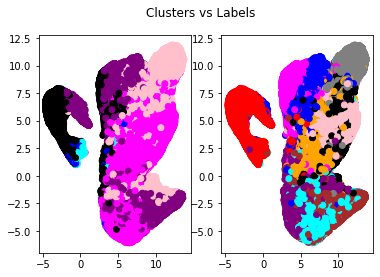

Epoch: 00 Loss: 177.202 | Rec-Loss: 0.243 | Dist-Loss: 176.960
Epoch: 01 | NMI: 0.424 | ARI: 0.296
Epoch: 01 | NMI: 0.424 | ARI: 0.296
Epoch: 01 Loss: 126.579 | Rec-Loss: 0.407 | Dist-Loss: 126.172
Epoch: 02 | NMI: 0.424 | ARI: 0.304
Epoch: 02 | NMI: 0.424 | ARI: 0.304
Epoch: 02 Loss: 103.730 | Rec-Loss: 0.491 | Dist-Loss: 103.239
Epoch: 03 | NMI: 0.438 | ARI: 0.311
Epoch: 03 | NMI: 0.438 | ARI: 0.311
Epoch: 03 Loss: 84.889 | Rec-Loss: 0.549 | Dist-Loss: 84.340
Epoch: 04 | NMI: 0.446 | ARI: 0.320
Epoch: 04 | NMI: 0.446 | ARI: 0.320
Epoch: 04 Loss: 71.875 | Rec-Loss: 0.507 | Dist-Loss: 71.368
Epoch: 05 | NMI: 0.421 | ARI: 0.324
Epoch: 05 | NMI: 0.421 | ARI: 0.324


/Users/shivin/miniconda/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


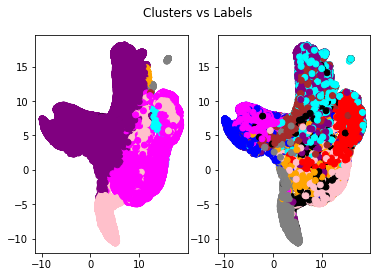

Epoch: 05 Loss: 62.240 | Rec-Loss: 0.505 | Dist-Loss: 61.735
Epoch: 06 | NMI: 0.410 | ARI: 0.309
Epoch: 06 | NMI: 0.410 | ARI: 0.309
Epoch: 06 Loss: 55.546 | Rec-Loss: 0.509 | Dist-Loss: 55.037
Epoch: 07 | NMI: 0.408 | ARI: 0.297
Epoch: 07 | NMI: 0.408 | ARI: 0.297
Epoch: 07 Loss: 49.907 | Rec-Loss: 0.501 | Dist-Loss: 49.406
Epoch: 08 | NMI: 0.412 | ARI: 0.294
Epoch: 08 | NMI: 0.412 | ARI: 0.294
Epoch: 08 Loss: 45.247 | Rec-Loss: 0.502 | Dist-Loss: 44.745
Epoch: 09 | NMI: 0.426 | ARI: 0.307
Epoch: 09 | NMI: 0.426 | ARI: 0.307
Epoch: 09 Loss: 40.893 | Rec-Loss: 0.504 | Dist-Loss: 40.390
Epoch: 10 | NMI: 0.431 | ARI: 0.305
Epoch: 10 | NMI: 0.431 | ARI: 0.305


/Users/shivin/miniconda/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


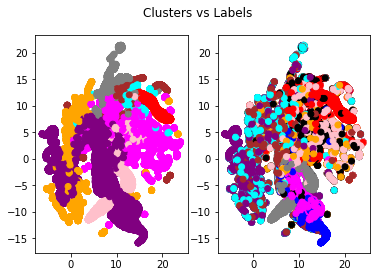

Epoch: 10 Loss: 37.106 | Rec-Loss: 0.503 | Dist-Loss: 36.603
Epoch: 11 | NMI: 0.431 | ARI: 0.303
Epoch: 11 | NMI: 0.431 | ARI: 0.303
Epoch: 11 Loss: 33.790 | Rec-Loss: 0.504 | Dist-Loss: 33.286
Epoch: 12 | NMI: 0.434 | ARI: 0.308
Epoch: 12 | NMI: 0.434 | ARI: 0.308
Epoch: 12 Loss: 30.887 | Rec-Loss: 0.503 | Dist-Loss: 30.384
Epoch: 13 | NMI: 0.431 | ARI: 0.301
Epoch: 13 | NMI: 0.431 | ARI: 0.301
Epoch: 13 Loss: 28.288 | Rec-Loss: 0.504 | Dist-Loss: 27.784
Epoch: 14 | NMI: 0.444 | ARI: 0.310
Epoch: 14 | NMI: 0.444 | ARI: 0.310
Epoch: 14 Loss: 26.036 | Rec-Loss: 0.504 | Dist-Loss: 25.533
Epoch: 15 | NMI: 0.449 | ARI: 0.314
Epoch: 15 | NMI: 0.449 | ARI: 0.314


/Users/shivin/miniconda/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


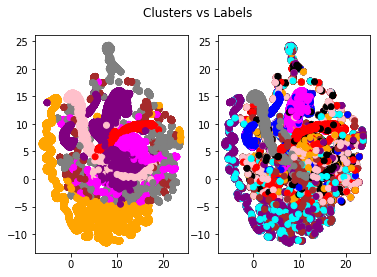

Epoch: 15 Loss: 24.050 | Rec-Loss: 0.503 | Dist-Loss: 23.547
Epoch: 16 | NMI: 0.452 | ARI: 0.314
Epoch: 16 | NMI: 0.452 | ARI: 0.314
Epoch: 16 Loss: 22.207 | Rec-Loss: 0.500 | Dist-Loss: 21.707
Epoch: 17 | NMI: 0.453 | ARI: 0.315
Epoch: 17 | NMI: 0.453 | ARI: 0.315
Epoch: 17 Loss: 20.612 | Rec-Loss: 0.498 | Dist-Loss: 20.114
Epoch: 18 | NMI: 0.454 | ARI: 0.317
Epoch: 18 | NMI: 0.454 | ARI: 0.317
Epoch: 18 Loss: 19.183 | Rec-Loss: 0.496 | Dist-Loss: 18.687
Epoch: 19 | NMI: 0.453 | ARI: 0.312
Epoch: 19 | NMI: 0.453 | ARI: 0.312
Epoch: 19 Loss: 17.857 | Rec-Loss: 0.495 | Dist-Loss: 17.362
Epoch: 20 | NMI: 0.356 | ARI: 0.188
Epoch: 20 | NMI: 0.356 | ARI: 0.188


/Users/shivin/miniconda/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


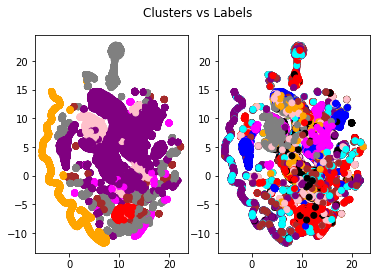

Epoch: 20 Loss: 16.599 | Rec-Loss: 0.493 | Dist-Loss: 16.106
Epoch: 21 | NMI: 0.453 | ARI: 0.311
Epoch: 21 | NMI: 0.453 | ARI: 0.311
Epoch: 21 Loss: 15.423 | Rec-Loss: 0.493 | Dist-Loss: 14.930
Epoch: 22 | NMI: 0.449 | ARI: 0.308
Epoch: 22 | NMI: 0.449 | ARI: 0.308
Epoch: 22 Loss: 14.340 | Rec-Loss: 0.497 | Dist-Loss: 13.843
Epoch: 23 | NMI: 0.446 | ARI: 0.305
Epoch: 23 | NMI: 0.446 | ARI: 0.305
Epoch: 23 Loss: 13.329 | Rec-Loss: 0.492 | Dist-Loss: 12.837
Epoch: 24 | NMI: 0.449 | ARI: 0.306
Epoch: 24 | NMI: 0.449 | ARI: 0.306
Epoch: 24 Loss: 12.392 | Rec-Loss: 0.493 | Dist-Loss: 11.899
Epoch: 25 | NMI: 0.447 | ARI: 0.305
Epoch: 25 | NMI: 0.447 | ARI: 0.305


/Users/shivin/miniconda/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


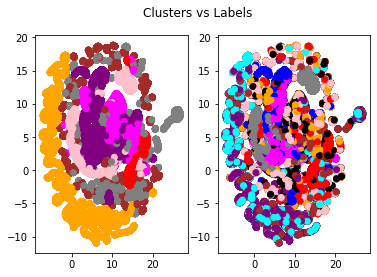

Epoch: 25 Loss: 11.541 | Rec-Loss: 0.498 | Dist-Loss: 11.043
Epoch: 26 | NMI: 0.446 | ARI: 0.307
Epoch: 26 | NMI: 0.446 | ARI: 0.307
Epoch: 26 Loss: 10.756 | Rec-Loss: 0.493 | Dist-Loss: 10.263
Epoch: 27 | NMI: 0.445 | ARI: 0.306
Epoch: 27 | NMI: 0.445 | ARI: 0.306
Epoch: 27 Loss: 10.047 | Rec-Loss: 0.496 | Dist-Loss: 9.552
Epoch: 28 | NMI: 0.444 | ARI: 0.306
Epoch: 28 | NMI: 0.444 | ARI: 0.306
Epoch: 28 Loss: 9.390 | Rec-Loss: 0.496 | Dist-Loss: 8.894
Epoch: 29 | NMI: 0.444 | ARI: 0.305
Epoch: 29 | NMI: 0.444 | ARI: 0.305
Epoch: 29 Loss: 8.788 | Rec-Loss: 0.496 | Dist-Loss: 8.292
Epoch: 30 | NMI: 0.445 | ARI: 0.306
Epoch: 30 | NMI: 0.445 | ARI: 0.306


/Users/shivin/miniconda/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


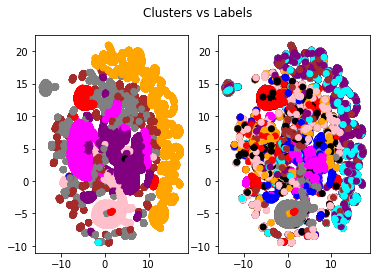

Epoch: 30 Loss: 8.229 | Rec-Loss: 0.493 | Dist-Loss: 7.736
Epoch: 31 | NMI: 0.449 | ARI: 0.307
Epoch: 31 | NMI: 0.449 | ARI: 0.307
Epoch: 31 Loss: 7.718 | Rec-Loss: 0.494 | Dist-Loss: 7.224
Epoch: 32 | NMI: 0.448 | ARI: 0.306
Epoch: 32 | NMI: 0.448 | ARI: 0.306
Epoch: 32 Loss: 7.243 | Rec-Loss: 0.492 | Dist-Loss: 6.751
Epoch: 33 | NMI: 0.450 | ARI: 0.307
Epoch: 33 | NMI: 0.450 | ARI: 0.307
Epoch: 33 Loss: 6.804 | Rec-Loss: 0.493 | Dist-Loss: 6.311
Epoch: 34 | NMI: 0.448 | ARI: 0.306
Epoch: 34 | NMI: 0.448 | ARI: 0.306
Epoch: 34 Loss: 6.393 | Rec-Loss: 0.491 | Dist-Loss: 5.901
Epoch: 35 | NMI: 0.447 | ARI: 0.304
Epoch: 35 | NMI: 0.447 | ARI: 0.304


/Users/shivin/miniconda/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


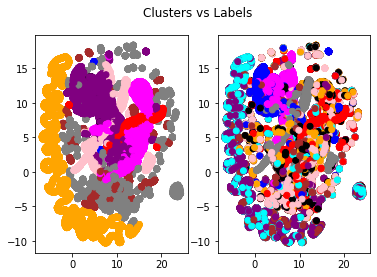

Epoch: 35 Loss: 6.011 | Rec-Loss: 0.492 | Dist-Loss: 5.519
Epoch: 36 | NMI: 0.448 | ARI: 0.305
Epoch: 36 | NMI: 0.448 | ARI: 0.305
Epoch: 36 Loss: 5.655 | Rec-Loss: 0.495 | Dist-Loss: 5.159
Epoch: 37 | NMI: 0.453 | ARI: 0.309
Epoch: 37 | NMI: 0.453 | ARI: 0.309
Epoch: 37 Loss: 5.342 | Rec-Loss: 0.520 | Dist-Loss: 4.823
Epoch: 38 | NMI: 0.453 | ARI: 0.309
Epoch: 38 | NMI: 0.453 | ARI: 0.309
Epoch: 38 Loss: 5.012 | Rec-Loss: 0.501 | Dist-Loss: 4.511
Epoch: 39 | NMI: 0.453 | ARI: 0.309
Epoch: 39 | NMI: 0.453 | ARI: 0.309
Epoch: 39 Loss: 4.723 | Rec-Loss: 0.497 | Dist-Loss: 4.226
Epoch: 40 | NMI: 0.452 | ARI: 0.307
Epoch: 40 | NMI: 0.452 | ARI: 0.307


/Users/shivin/miniconda/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


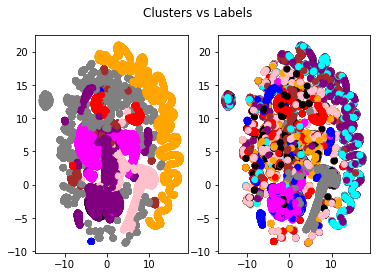

Epoch: 40 Loss: 4.470 | Rec-Loss: 0.501 | Dist-Loss: 3.969
Epoch: 41 | NMI: 0.452 | ARI: 0.307
Epoch: 41 | NMI: 0.452 | ARI: 0.307
Epoch: 41 Loss: 4.235 | Rec-Loss: 0.500 | Dist-Loss: 3.735
Epoch: 42 | NMI: 0.452 | ARI: 0.307
Epoch: 42 | NMI: 0.452 | ARI: 0.307
Epoch: 42 Loss: 4.019 | Rec-Loss: 0.499 | Dist-Loss: 3.520
Epoch: 43 | NMI: 0.451 | ARI: 0.305
Epoch: 43 | NMI: 0.451 | ARI: 0.305
Epoch: 43 Loss: 3.819 | Rec-Loss: 0.497 | Dist-Loss: 3.322
Epoch: 44 | NMI: 0.450 | ARI: 0.304
Epoch: 44 | NMI: 0.450 | ARI: 0.304
Epoch: 44 Loss: 3.638 | Rec-Loss: 0.501 | Dist-Loss: 3.137
Epoch: 45 | NMI: 0.450 | ARI: 0.304
Epoch: 45 | NMI: 0.450 | ARI: 0.304


/Users/shivin/miniconda/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


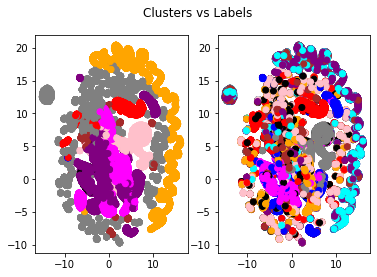

Epoch: 45 Loss: 3.461 | Rec-Loss: 0.498 | Dist-Loss: 2.963
Epoch: 46 | NMI: 0.451 | ARI: 0.305
Epoch: 46 | NMI: 0.451 | ARI: 0.305
Epoch: 46 Loss: 3.298 | Rec-Loss: 0.497 | Dist-Loss: 2.801
Epoch: 47 | NMI: 0.450 | ARI: 0.305
Epoch: 47 | NMI: 0.450 | ARI: 0.305
Epoch: 47 Loss: 3.144 | Rec-Loss: 0.495 | Dist-Loss: 2.649
Epoch: 48 | NMI: 0.450 | ARI: 0.305
Epoch: 48 | NMI: 0.450 | ARI: 0.305
Epoch: 48 Loss: 2.998 | Rec-Loss: 0.491 | Dist-Loss: 2.507
Epoch: 49 | NMI: 0.451 | ARI: 0.306
Epoch: 49 | NMI: 0.451 | ARI: 0.306
Epoch: 49 Loss: 2.868 | Rec-Loss: 0.492 | Dist-Loss: 2.377
Epoch: 50 | NMI: 0.450 | ARI: 0.306
Epoch: 50 | NMI: 0.450 | ARI: 0.306


In [99]:
model.args = args
# model.clustering = initial_clustering
reducer = umap.UMAP()
for e in range(args.epoch):
    # Print training set
    if e%5 == 0:
        X_train = X_train.view(len(X_train), -1)
        out = model.autoencoder(torch.FloatTensor(np.array(X_train)).to(args.device), latent=True)
        cluster_id = model.clustering.update_assign(out.cpu().detach().numpy())
        
        X2 = reducer.fit_transform(out.cpu().detach().numpy())
#         X2 = out.cpu().detach().numpy()

        X_centers = reducer.transform(model.clustering.clusters)

        c_clusters = [color[int(cluster_id[i])] for i in range(len(cluster_id))]
        c_labels = [color[int(y_train[i])] for i in range(len(cluster_id))]
#         plt.scatter(latent_X[:,0], latent_X[:,1], color=c_train); plt.show()

        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Clusters vs Labels')
        ax1.scatter(X2[:,0], X2[:,1], color=c_clusters)
#         ax1.plot(X_centers[0], marker='x', markersize=3, color="green")
#         ax1.plot(X_centers[1], marker='x', markersize=3, color="green")

        ax2.scatter(X2[:,0], X2[:,1], color=c_labels)
        plt.show()

        # Print testset
        """
        out = model.autoencoder(torch.FloatTensor(np.array(X_test)).to(args.device), latent=True)
        test_cluster_id = model.clustering.update_assign(out.cpu().detach().numpy())
        X_t = reducer.transform(out.cpu().detach().numpy())
#         X_t = out.cpu().detach().numpy()

        c_clusters = [color[int(test_cluster_id[i])] for i in range(len(test_cluster_id))]
        c_test = [color[int(y_test[i])] for i in range(len(y_test))]

        figure = plt.figure()
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('CAC Testing Clusters vs Testing Embeddings')
        ax1.scatter(X_t[:,0], X_t[:,1], color=c_clusters)
        ax2.scatter(X_t[:,0], X_t[:,1], color=c_test)
        plt.show()"""

    model.train()
    model.fit(e, train_loader)

    model.eval()
    out = evaluate(model, test_loader)  # evaluation on the test_loader
    if len(out) > 2:
        NMI, ARI, base_f1, base_mcc, base_auc, cac_f1, cac_mcc, cac_auc = out
        print('Epoch: {:02d} | NMI: {:.3f} | ARI: {:.3f} | Base_F1: {:.3f} | Base_MCC: {:.3f} | Base_AUC: {:.3f} | CAC_F1: {:.3f} | CAC_MCC: {:.3f} | CAC_AUC: {:.3f}'.format(
                e+1, NMI, ARI, base_f1, base_mcc, base_auc, cac_f1, cac_mcc, cac_auc))
    else:
        NMI, ARI = out
        print('Epoch: {:02d} | NMI: {:.3f} | ARI: {:.3f}'.format(
                e+1, NMI, ARI))
    nmi_list.append(NMI)
    ari_list.append(ARI)
    print('Epoch: {:02d} | NMI: {:.3f} | ARI: {:.3f}'.format(
            e+1, NMI, ARI))


In [ ]:
class NNClassifier(nn.Module):
    def __init__(self, args):
        super(NNClassifier, self).__init__()
        self.args = args
        self.input_dim = args.latent_dim
        self.n_classes = args.n_classes
        self.criterion = nn.CrossEntropyLoss(reduction='mean')
#         self.train_loss = None
        self.classifier = nn.Sequential(
            nn.Linear(self.input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, args.n_classes),
#             nn.Sigmoid()
        )
        
        self.optimizer = torch.optim.Adam(self.classifier.parameters(), lr=args.lr)
#         self.dropout = nn.Dropout(p=0.1)
#         self.batchnorm1 = nn.BatchNorm1d(64)
#         self.batchnorm2 = nn.BatchNorm1d(64)

    def forward(self, inputs):
        return self.classifier(inputs)

    def fit(self, X_batch, y_batch):
        self.optimizer.zero_grad()
        self.classifier.train()
        y_pred = self.forward(X_batch.detach())
        train_loss = self.criterion(y_pred, y_batch)
        train_loss.backward()
        self.optimizer.step()
        return y_pred.detach().numpy(), train_loss.item()

In [ ]:
# Training separate models
args.lr = 0.02
classifiers = [NNClassifier(args) for _ in range(args.n_clusters)]
# optimizers = [torch.optim.Adam(classifiers[i].classifier.parameters(), lr=args.lr) for i in range(args.n_clusters)]
EPOCHS = 400
device = 'cpu'
model.eval()

latents_X = model.autoencoder(torch.FloatTensor(np.array(X_train)).to(args.device), latent=True)

cluster_id_train = model.clustering.update_assign(latents_X.cpu().detach().numpy())
X_latents_data_loader = list(zip(latents_X, cluster_id_train, y_train))

train_loader_latents = torch.utils.data.DataLoader(X_latents_data_loader,
    batch_size=1024, shuffle=False)

latents_test = model.autoencoder(torch.FloatTensor(np.array(X_test)).to(args.device), latent=True)
cluster_id_test = model.clustering.update_assign(latents_test.cpu().detach().numpy())


X2 = reducer.fit_transform(latents_X.cpu().detach().numpy())

c_clusters = [color[int(cluster_id_train[i])] for i in range(len(cluster_id_train))]
c_labels = [color[int(y_train[i])] for i in range(len(cluster_id_train))]
# plt.scatter(latent_X[:,0], latent_X[:,1], color=c_train); plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Clusters vs Labels')
ax1.scatter(X2[:,0], X2[:,1], color=c_clusters)
ax2.scatter(X2[:,0], X2[:,1], color=c_labels)
plt.show()


X2 = reducer.fit_transform(latents_test.cpu().detach().numpy())

c_clusters = [color[int(cluster_id_test[i])] for i in range(len(cluster_id_test))]
c_labels = [color[int(y_test[i])] for i in range(len(cluster_id_test))]
# plt.scatter(latent_X[:,0], latent_X[:,1], color=c_train); plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Clusters vs Labels')
ax1.scatter(X2[:,0], X2[:,1], color=c_clusters)
ax2.scatter(X2[:,0], X2[:,1], color=c_labels)
plt.show()

for e in range(1, EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    alpha = (1-e/EPOCHS)
    acc = 0
    for X_batch, cluster_batch, y_batch in train_loader_latents:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        new_y_batch = []
        y_pred = []
        for k in range(args.n_clusters):
            idx = np.where(cluster_batch == k)[0]
            y_pred_idx, loss = classifiers[k].fit(X_batch[idx], y_batch[idx])
            y_pred.append(y_pred_idx)
            new_y_batch.append(y_batch[idx].detach().numpy())
            epoch_loss += loss
#             print("Cluster: ", k, "F1: ", f1_score(np.argmax(y_pred_idx, axis=1), y_batch[idx].detach().numpy()))
#             print(len(idx), np.argmax(y_pred_idx, axis=1))
#             print(y_pred_idx, y_batch[idx])
#             if k == 1 :
#                 print(e, X_batch)
#                 X2 = reducer.fit_transform(latents[idx].cpu().detach().numpy())

#                 c_clusters = [color[int(cluster_id[i])] for i in range(len(cluster_id[idx]))]
#                 c_labels = [color[int(y_train[i])] for i in range(len(cluster_id[idx]))]
#         #         plt.scatter(latent_X[:,0], latent_X[:,1], color=c_train); plt.show()

#                 fig, (ax1, ax2) = plt.subplots(1, 2)
#                 fig.suptitle('Clusters vs Labels')
#                 ax1.scatter(X2[:,0], X2[:,1], color=c_clusters)
#                 plt.show()

        
        y_pred = np.vstack(y_pred)
        new_y_batch = np.hstack(new_y_batch)
        
        acc = f1_score(np.argmax(y_pred, axis=1), new_y_batch)
#         acc = roc_auc_score(new_y_batch, y_pred[:,1])
        epoch_acc += acc.item()

    test_preds = []
    test_loss = 0.0
    new_y_test = []
    for k in range(args.n_clusters):
        classifiers[k].classifier.eval()
        idx = np.where(cluster_id_test == k)[0]
        latents_idx = latents_test[idx]
        y_pred_idx = classifiers[k](latents_idx)
        test_loss += nn.CrossEntropyLoss(reduction='mean')(y_pred_idx, torch.tensor(y_test[idx]).to(device))
        test_preds.append(y_pred_idx.detach().numpy())
        new_y_test.append(y_test[idx])

    test_preds = np.vstack(test_preds)
    new_y_test = np.hstack(new_y_test).reshape(-1)
    test_f1 = f1_score(np.argmax(test_preds, axis=1), new_y_test)
#     test_f1 = roc_auc_score(new_y_test, test_preds[:,1])

    print(f'Epoch {e+0:03}: | Train Loss: {epoch_loss/len(train_loader):.5f} | Train Acc: {epoch_acc/len(train_loader):.3f} | Test Acc: {test_f1:.3f} | Test Loss: {test_loss:.3f}')

out = model.autoencoder(torch.FloatTensor(np.array(X_train)).to(args.device), latent=True)
cluster_id = model.clustering.update_assign(out.cpu().detach().numpy())


# No Batch

In [ ]:
# Training separate models
args.lr = 0.002
classifiers = [NNClassifier(args) for _ in range(args.n_clusters)]
# optimizers = [torch.optim.Adam(classifiers[i].classifier.parameters(), lr=args.lr) for i in range(args.n_clusters)]
EPOCHS = 300
device = 'cpu'
model.eval()

latents_X = model.autoencoder(torch.FloatTensor(np.array(X_train)).to(args.device), latent=True)

cluster_id_train = model.clustering.update_assign(latents_X.detach().numpy())
X_latents_data_loader = list(zip(latents_X, cluster_id, y_train))

train_loader_latents = torch.utils.data.DataLoader(X_latents_data_loader,
    batch_size=1024, shuffle=False)

latents_test = model.autoencoder(torch.FloatTensor(np.array(X_test)).to(args.device), latent=True)
cluster_id_test = model.clustering.update_assign(latents_test.cpu().detach().numpy())

X2 = reducer.fit_transform(latents_X.cpu().detach().numpy())

c_clusters = [color[int(cluster_id_train[i])] for i in range(len(cluster_id_train))]
c_labels = [color[int(y_train[i])] for i in range(len(cluster_id_train))]
# plt.scatter(latent_X[:,0], latent_X[:,1], color=c_train); plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Clusters vs Labels')
ax1.scatter(X2[:,0], X2[:,1], color=c_clusters)
ax2.scatter(X2[:,0], X2[:,1], color=c_labels)
plt.show()


X2 = reducer.fit_transform(latents_test.cpu().detach().numpy())

c_clusters = [color[int(cluster_id_test[i])] for i in range(len(cluster_id_test))]
c_labels = [color[int(y_test[i])] for i in range(len(cluster_id_test))]
# plt.scatter(latent_X[:,0], latent_X[:,1], color=c_train); plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Clusters vs Labels')
ax1.scatter(X2[:,0], X2[:,1], color=c_clusters)
ax2.scatter(X2[:,0], X2[:,1], color=c_labels)
plt.show()


for e in range(1, EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    alpha = (1-e/EPOCHS)
    acc = 0

    new_y = []
    y_pred = []
    for k in range(args.n_clusters):
#         print("Training on cluster: ", k)
        idx = np.where(cluster_id_train == k)[0]
        y_pred_idx, loss = classifiers[k].fit(latents_X[idx], torch.tensor(y_train[idx]).to(device))
        y_pred.append(y_pred_idx)
        new_y.append(y_train[idx])
        epoch_loss += loss
#         print("Cluster: ", k, "F1: ", accuracy_score(np.argmax(y_pred_idx, axis=1), y_train[idx]), "loss: ", loss)
#         print(len(idx), np.argmax(y_pred_idx, axis=1))
#         print(y_pred_idx, y_train[idx])
    y_pred = np.vstack(y_pred)
    new_y = np.hstack(new_y)

#     acc = accuracy_score(np.argmax(y_pred, axis=1), new_y)
    acc = roc_auc_score(new_y, y_pred[:,1])
    epoch_acc += acc.item()

    test_preds = []
    test_loss = 0.0
    new_y_test = []
    for k in range(args.n_clusters):
        classifiers[k].classifier.eval()
        idx = np.where(cluster_id_test == k)[0]
        latents_idx = latents_test[idx]
        y_pred_idx = classifiers[k](latents_idx)
        test_loss += nn.CrossEntropyLoss(reduction='mean')(y_pred_idx, torch.tensor(y_test[idx]).to(device))
        test_preds.append(y_pred_idx.detach().numpy())
        new_y_test.append(y_test[idx])

    test_preds = np.vstack(test_preds)
    new_y_test = np.hstack(new_y_test).reshape(-1)
#     test_f1 = accuracy_score(np.argmax(test_preds, axis=1), new_y_test)
    test_f1 = roc_auc_score(new_y_test, test_preds[:,1])

    print(f'Epoch {e+0:03}: | Train Loss: {epoch_loss:.5f} | Train Acc: {epoch_acc:.3f} | Test Acc: {test_f1:.3f} | Test Loss: {test_loss:.3f}')

out = model.autoencoder(torch.FloatTensor(np.array(X_train)).to(args.device), latent=True)
cluster_id = model.clustering.update_assign(out.cpu().detach().numpy())  

# Base Approch

In [3]:
args.latent_dim = args.input_dim
print(X_train.shape)
m = NNClassifier(args)
print(m)
EPOCHS = 100
device = 'cpu'
model.eval()

for e in range(1, EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    alpha = (1-e/EPOCHS)
    acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#         latents = model.autoencoder(torch.FloatTensor(np.array(X_batch)).to(args.device), latent=True)
#         cluster_id = model.clustering.update_assign(latents.cpu().detach().numpy())
        
        y_pred, train_loss = m.fit(X_batch, y_batch)
        epoch_loss += train_loss

        acc = f1_score(np.argmax(y_pred, axis=1), y_batch.detach().numpy())
#         acc = roc_auc_score(y_batch.detach().numpy(), y_pred[:,1].detach().numpy())
        epoch_acc += acc.item()

    test_loss = 0.0

    m.classifier.eval()
    test_pred = m(torch.FloatTensor(np.array(X_test)).to(args.device))
    test_loss += nn.CrossEntropyLoss(reduction='mean')(test_pred, torch.tensor(y_test).to(device))

    test_f1 = f1_score(np.argmax(test_pred.detach().numpy(), axis=1), y_test)
#     test_f1 = roc_auc_score(y_test, test_pred[:,1].detach().numpy())

    print(f'Epoch {e+0:03}: | Train Loss: {epoch_loss/len(train_loader):.5f} | Train Acc: {epoch_acc/len(train_loader):.3f} | Test Acc: {test_f1:.3f} | Test Loss: {test_loss:.3f}')

out = model.autoencoder(torch.FloatTensor(np.array(X_train)).to(args.device), latent=True)
cluster_id = model.clustering.update_assign(out.cpu().detach().numpy())


NameError: name 'X_train' is not defined

In [ ]:
params['n_clusters'] = 2
args = parameters(params)
datasets = ['titanic', 'magic', 'creditcard', 'adult', 'diabetes', 'cic', 'synthetic', 'new_synthetic']

In [ ]:
if args.dataset in datasets:
    base_dir = "../../CAC_code/data"
    print("Loading Dataset:", args.dataset)
    if args.dataset == "synthetic":
        n_feat = 45
        X, y = create_imbalanced_data_clusters(n_samples=500, n_clusters=2, n_features = n_feat, inner_class_sep=0.2, seed=0)
        X = pd.DataFrame(X)
        y = pd.DataFrame(y)
        args.input_dim = n_feat

    elif args.dataset == "paper_synthetic":
        n_feat = 100
        X, y = paper_synthetic(10000)
        X = pd.DataFrame(X)
        y = pd.DataFrame(y)
        args.input_dim = n_feat

    else:
        X, y = get_dataset(args.dataset, base_dir)
        args.input_dim = X.shape[1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)

    X_train_data_loader = list(zip(X_train.astype(np.float32), y_train))
    X_test_data_loader  = list(zip(X_test.astype(np.float32), y_test))

    train_loader = torch.utils.data.DataLoader(X_train_data_loader,
        batch_size=args.batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(X_test_data_loader, 
        batch_size=args.batch_size, shuffle=False)

elif args.dir == "../datasets/mnist":
    # Load data
    transformer = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,),
                                                           (0.3081,))])

    train_set = datasets.MNIST(args.dir, train=True, download=True, transform=transformer)
    test_set  = datasets.MNIST(args.dir, train=False, transform=transformer)
    train_limit = list(range(0, len(train_set))) if not args.test_run else list(range(0, 500))    
    test_limit  = list(range(0, len(test_set)))  if not args.test_run else list(range(0, 500))    

    train_loader = torch.utils.data.DataLoader(Subset(train_set, train_limit),
        batch_size=args.batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(Subset(test_set, test_limit), 
        batch_size=args.batch_size, shuffle=False)

In [ ]:
model3 = DCN(args)
rec_loss_list = model3.pretrain(train_loader, epoch=args.pre_epoch)
pre_trained_AE = model3.autoencoder
# model.autoencoder = pre_trained_AE
# initial_clustering = model.clustering
# model.pre_cluster(train_loader)
# model.pre_cluster(train_loader)
nmi_list = []
ari_list = []

In [ ]:
model3.args = args
# model.clustering = initial_clustering
reducer = umap.UMAP()
for e in range(args.epoch):
    # Show training set
    if e%1 == 0:
        out = model.autoencoder(torch.FloatTensor(np.array(X_train)).to(args.device), latent=True)
        cluster_id = model.clustering.update_assign(out.cpu().detach().numpy())
        X2 = reducer.fit_transform(out.cpu().detach().numpy())

#         X_centers = reducer.transform(model.clustering.clusters)

        c_clusters = [color[int(cluster_id[i])] for i in range(len(cluster_id))]
        c_labels = [color[int(y_train[i])] for i in range(len(cluster_id))]
        # plt.scatter(latent_X[:,0], latent_X[:,1], color=c_train); plt.show()

        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Clusters vs Labels')
        ax1.scatter(X2[:,0], X2[:,1], color=c_clusters)
#         ax1.plot(X_centers[0], marker='x', markersize=3, color="green")
#         ax1.plot(X_centers[1], marker='x', markersize=3, color="green")

        ax2.scatter(X2[:,0], X2[:,1], color=c_labels)
        plt.show()

        # Print testset
        out = model.autoencoder(torch.FloatTensor(np.array(X_test)).to(args.device), latent=True)
        test_cluster_id = model.clustering.update_assign(out.cpu().detach().numpy())
        X_t = reducer.transform(out.cpu().detach().numpy())

        c_clusters = [color[int(test_cluster_id[i])] for i in range(len(test_cluster_id))]
        c_test = [color[int(y_test[i])] for i in range(len(y_test))]

        figure = plt.figure()
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('CAC Testing Clusters vs Testing Embeddings')
        ax1.scatter(X_t[:,0], X_t[:,1], color=c_clusters)
        ax2.scatter(X_t[:,0], X_t[:,1], color=c_test)
        plt.show()

    model.train()
    model.fit(e, train_loader)

    model.eval()
    NMI, ARI, base_f1, base_auc, cac_f1, cac_auc = evaluate(model, test_loader)  # evaluation on the test_loader
    nmi_list.append(NMI)
    ari_list.append(ARI)

    print('Epoch: {:02d} | NMI: {:.3f} | ARI: {:.3f} | Base_F1: {:.3f} | Base_AUC: {:.3f} | CAC_F1: {:.3f} | CAC_F1: {:.3f}'.format(
        e+1, NMI, ARI, base_f1, base_auc, cac_f1, cac_auc))
